# **Xây dựng Mạng thần kinh tích chập (Convolutional Neural Network) bằng Deep Learning**
Trong notebook này, chúng ta sẽ xây dựng một mô hình **CNN** được sử dụng để phân loại ảnh chó và mèo bằng cách sử dụng **thư viện keras và backend tensorflow**. Ngoài ra, chúng ta sẽ sử dụng **transfer learning** để tải một mô hình được xác định trước VGG16 và sử dụng nó để phân loại các ảnh. Các bước khác nhau mà chúng ta sẽ thực hiện để xây dựng các mô hình như sau:

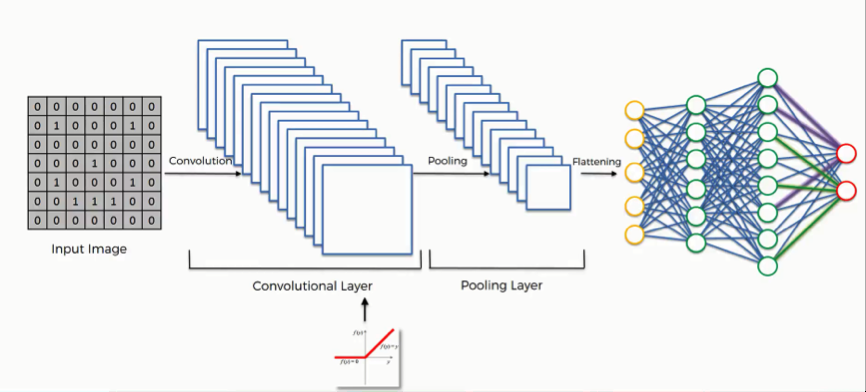
* Chuẩn bị dữ liệu


    1. Nhập các thư viện và gắn kết dữ liệu.
    2. Giải nén dữ liệu.
    3. Hiển thị các ảnh ngẫu nhiên của chó và mèo từ dữ liệu.
    4. Tạo thư mục cho dữ liệu đào tạo (training), xác thực (validaton) và kiểm tra (testing data).
    5. Chia dữ liệu đào tạo thành hai phần.
        
* Xây dựng mô hình CNN
* Thực hiện tăng cường dữ liệu (Data Augmentation) trên dữ liệu đào tạo (training data) và kiểm tra (test data).
* Xây dựng chức năng Callback Functions
* Đưa mô hình CNN vào dữ liệu.
* Đánh giá và dự đoán kết quả.
* Lưu mô hình và các trọng số (weights).
* Tải mô hình VGG16 cho transfer learning.
* Đưa mô hình VGG16 vào dữ liệu.
* Đánh giá kết quả của mô hình VGG16.


---

##          ***Nhập thư viện và gắn dữ liệu***

In [ ]:
# !pip install pandas 2.0.1
# !pip install keras keras-2.12.0
# !pip install tensorflow 2.12.0
# !pip install livelossplot 0.5.5


# !pip list

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPool2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

from keras.optimizers import SGD
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger

from livelossplot import PlotLossesKeras
from keras.applications import VGG16
from keras.models import Model
import os
import zipfile
import glob
import shutil

print('imported libraries')

In [ ]:
# Kiểm tra tập dữ liệu (datasets) trong hệ thống tập tin
print(os.listdir('input/dogs-vs-cats'))

# Tạo đường dẫn cho train & test
pathData = 'working/data/'
if os.path.exists(pathData):
    print('That path already exists: ', pathData)
else:
    os.makedirs(pathData)
    print('Created that path: ', pathData)

## *Giải nén dữ liệu*

In [ ]:
# Giải nén dữ liệu
zip_files = glob.glob('input/*/*.zip')
print(zip_files)

# giải nén tập tin vào một thư mục tạm thời
def extract_zip(file):
    with zipfile.ZipFile(file,"r") as zip_ref:
        zip_ref.extractall(pathData)
        
# Giải nén cả train.zip và test1.zip
for files in zip_files:
    extract_zip(files)
print('Unzipped')

In [ ]:
# Kiểm tra các tệp mới cùng với số lượng mẫu 
print(len(os.listdir('working/data/train')),'Training Samples')
print(len(os.listdir('working/data/test1')),'Testing Samples')

In [ ]:
# Kiểm tra tên của một vài mẫu dữ liệu
print(os.listdir('working/data/train')[:5])

## *Hiển thị hình ảnh ngẫu nhiên của chó và mèo từ dữ liệu*

In [ ]:
# Chỉ định kích thước tổng thể của lưới
plt.figure(figsize=(10,10))

# Định nghĩa vị trí tập dữ liệu
folder = 'working/data/train'
for i in range(25):
	plt.subplot(5,5,i+1)    # số lượng hình ảnh trong lưới là 55 range(25)
	filename = folder + '/dog.' + str(i) + '.jpg'
    
	# Tải các hình ảnh pixel
	image = imread(filename)
    
	# Hiển thị dữ liệu pixel thô (raw)
	plt.imshow(image)
plt.show()

In [ ]:
# Hiển thị hình ảnh chó từ tập dữ liệu chó và mèo

# Định nghĩa vị trí tập dữ liệu
folder = 'working/data/train'

# Hiển thị 1 số  hình ảnh đầu tiên
for i in range(9):
	# Định nghĩa subplot
	plt.subplot(330 + 1 + i)
	# Định nghĩa tên tệp
	filename = folder + '/dog.' + str(i) + '.jpg'
	# Định nghĩa tên tệp
	image = imread(filename)
	# Hiển thị dữ liệu pixel thô
	plt.imshow(image, aspect = 'auto')
# Hiển thị hình ảnh
plt.show()

In [ ]:
# Hiển thị hình ảnh mèo từ tập dữ liệu chó và mèo

# define location of dataset
folder = 'working/data/train'
# plot first few images
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # Định nghĩa tên tệp
    filename = folder + '/cat.' + str(i) + '.jpg'
    # Định nghĩa tên tệp
    image = imread(filename)
    # Hiển thị dữ liệu pixel thô
    plt.imshow(image, aspect = 'auto')
# Hiển thị hình ảnh
plt.show()

## *Tạo thư mục cho Training, Validation and Testing Data*

In [ ]:
# Tạo các thư mục mới cho training data và validation data
dataset_home = 'dataset/'
subdirs = ['training_set/', 'validation_set/']
for subdir in subdirs:
	# Tạo các thư mục con theo nhãn
	labeldirs = ['dogs/', 'cats/']
	for labldir in labeldirs:
		newdir = dataset_home + subdir + labldir
		os.makedirs(newdir, exist_ok=True)
		print('Created path: ', newdir)

In [ ]:
# Tạo thư mục mới cho test data
testdir = dataset_home + 'testing_set'
os.makedirs(testdir, exist_ok= True)

# Tạo thư mục mới cho ảnh test data và in ra thông báo
dirs = 'working/dataset/testing_set/' + 'Test'
os.makedirs(dirs,exist_ok = True)
print('Created that path: ', dirs)

In [ ]:
# In ra danh sách các file và thư mục trong thư mục dataset_home
print(os.listdir(dataset_home))

## *Chia dữ liệu huấn luyện thành hai phần*

In [ ]:
# Chia tập dữ liệu huấn luyện (training data) thành hai phần, một phần để huấn luyện (training) và phần còn lại để kiểm định (validation)

# khởi tạo bộ sinh số ngẫu nhiên
from random import random
from random import seed
seed(1)

# xác định tỷ lệ ảnh sử dụng cho kiểm định (validation)
validation_ratio = 0.25

# sao chép hình ảnh tập dữ liệu huấn luyện (training) vào các thư mục con
from shutil import copyfile
training_source = 'working/data/train/'
for file in os.listdir(training_source):
	src = training_source + '/' + file
	destination = 'training_set/'
	if random() < validation_ratio:
		destination = 'validation_set/'
	if file.startswith('cat'):
		dst = dataset_home + destination + 'cats/'  + file
		copyfile(src, dst)
		print('added to cat: ', src, dst)
	elif file.startswith('dog'):
		dst = dataset_home + destination + 'dogs/'  + file
		copyfile(src, dst)
		print('added to dog: ', src, dst)
        
print('Chia tập dữ liệu huấn luyện thành công!')

In [ ]:
# Xóa các hình ảnh trong thư mục kiểm tra để có kết quả trên các hình ảnh ngẫu nhiên hơn (sử dụng để có những ảnh mẫu ngẫu nhiên)
a = glob.glob('working/dataset/testing_set/Test/*.jpg')
for j in a:
    os.remove(j)
print('removed all image in folder Test')

#### Lấy ra 10 image ngẫu nhiên và lưu vào 'working/dataset/testing_set/Test/' 
    - Lưu ý là mỗi lần chạy là lại lấy thêm 10 file image vì là random

In [ ]:
# Tạo một số mẫu để phân loại hình ảnh bằng mô hình đã xây dựng
test_source = "working/data/test1"
print(os.listdir(test_source)[:5])

test_dest = "working/dataset/testing_set/Test"
# Chọn ngẫu nhiên 10 tệp từ thư mục test (working/data/test1)
random_samples = np.random.choice(os.listdir(test_source),10) # Sử dụng np.random.choice() để chọn ngẫu nhiên 10 tên tệp từ danh sách được trả về bởi os.listdir()
for file in random_samples:
    new_src = test_source + '/' + file
    shutil.copy(new_src,test_dest)
print(os.listdir(test_dest))

## *Xây dựng mô hình Convolutional Neural Network (CNN)*

In [ ]:
# Xây dựng mô hình CNN
model = Sequential()  # Tạo một đối tượng mô hình tuần tự (sequential model), đây là một mô hình xếp chồng các lớp (layer).

# Thêm lớp convolutional đầu tiên & thứ hai với 32 filters và kích thước kernel là 3x3, activation sử dụng hàm relu và thêm padding để giữ nguyên kích thước đầu vào
model.add(Conv2D(32, (3, 3), padding='same', input_shape=(200,200,3), activation='relu'))
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2))) # Thêm lớp max pooling với kích thước là 2x2

# Thêm lớp convolutional thứ ba & bốn với 64 filters và kích thước kernel là 3x3, activation sử dụng hàm relu
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))  # Thêm lớp max pooling với kích thước là 2x2

# Thêm lớp convolutional thứ năm & sáu với 128 filters và kích thước kernel là 3x3, activation sử dụng hàm relu
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))  # Thêm lớp max pooling với kích thước là 2x2

# Thêm lớp convolutional thứ bảy & tám với 256 filters và kích thước kernel là 3x3, activation sử dụng hàm relu
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))  # Thêm lớp max pooling với kích thước là 2x2

# Thêm lớp flatten để chuyển đổi đầu ra của các lớp trước đó thành một vector 1D có thể đưa vào lớp dense.
model.add(Flatten())
model.add(Dense(units = 256, activation='relu')) # Thêm lớp dense thứ nhất với 256 units và activation sử dụng hàm relu.
model.add(Dropout(0.5)) # Thêm lớp dropout với 0.5 giá trị dropout để tránh overfitting.

model.add(Dense(units = 256, activation='relu')) # Thêm lớp dense thứ hai với 256 units units relu.
model.add(Dropout(0.5)) # Thêm lớp dropout với 0.5 giá trị dropout để tránh overfitting.

# Cấu hình mô hình trước khi đào tạo (training)
# Thêm lớp dense cuối cùng với 1 units và activation sử dụng hàm sigmoid, phù hợp cho bài toán phân loại nhị phân.
model.add(Dense(units = 1, activation = 'sigmoid')) 

# Cấu hình model với hàm loss là binary_crossentropy, tối ưu hóa RMSprop và độ đánh giá accuracy.
model.compile(loss='binary_crossentropy',
            optimizer=RMSprop(learning_rate=0.0001),
            metrics=['accuracy'])

print('CNN model has already')

## *Thực hiện tăng cường dữ liệu (Data Augmentation) để ngăn chặn việc overfitting*

In [ ]:
# Chuẩn bị dữ liệu và thực hiện Data Augmentation
train_datagen = ImageDataGenerator(rescale=1./255,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True)

# Khởi tạo một đối tượng ImageDataGenerator cho tập "validation set". Chỉ có phép tăng cường rescale=1./255 được áp dụng cho các ảnh validation.
validation_datagen = ImageDataGenerator(rescale=1./255) 

# Khởi tạo một đối tượng ImageDataGenerator cho tập "test set". Tương tự như tập validation, chỉ có phép tăng cường rescale=1./255 được áp dụng cho các ảnh test.
test_datagen = ImageDataGenerator(rescale=1./255)

# Tạo các generator cho các tập dữ liệu huấn luyện, validation và kiểm tra
# Sử dụng train_datagen để tạo generator cho tập huấn luyện với các tham số cụ thể và lấy dữ liệu từ thư mục 'dataset/training_set'
train_set = train_datagen.flow_from_directory('dataset/training_set',
                                                target_size=(200, 200),
                                                batch_size=64,
                                                class_mode='binary')

# Sử dụng validation_datagen để tạo generator cho tập validation với các tham số cụ thể và lấy dữ liệu từ thư mục 'dataset/validation_set'
validation_set = validation_datagen.flow_from_directory('dataset/validation_set',
                                                target_size=(200, 200),
                                                batch_size=64,
                                                class_mode='binary')

# Sử dụng test_datagen để tạo generator cho tập kiểm tra với các tham số cụ thể và lấy dữ liệu từ thư mục 'kaggle/working/dataset/testing_set'
test_set = test_datagen.flow_from_directory('working/dataset/testing_set',
                                                target_size=(200, 200),
                                                batch_size=1,class_mode = 'binary',shuffle = False)

# *Generator cho tập huấn luyện và tập validation áp dụng Data Augmentation, nhưng generator cho tập kiểm tra không áp dụng Data Augmentation, chỉ áp dụng rescale=1./255.
print('Data Augmentation is success!')

## *Tạo tệp để lưu trữ mô hình*

In [ ]:
# Tạo các file trống để lưu trữ dữ liệu
with open('best_model.h5', 'w') as best:
    pass

# Tạo tệp CSV để lưu trữ losses
with open('CSVLogs.csv','w') as loss:
    pass

## *Xây dựng chức năng Callback Functions*

In [ ]:
# Tạo các callback functions
# EarlyStopping callback:
es = EarlyStopping(monitor='val_loss',mode= 'min',verbose=1,patience=10,restore_best_weights=True)
print('EarlyStopping callback is successfully!')

# ModelCheckpoint callback:
mc = ModelCheckpoint('best_model.h5',monitor='val_loss',mode= 'min',verbose=1,save_best_only=False)
print('ModelCheckpoint callback is successfully!')

# CSVLogger callback:
csv = CSVLogger('CSVLogs.csv',separator=',', append=False)
print('CSVLogger callback is successfully!')

## *Fitting mô hình CNN vào dữ liệu*

In [ ]:
output = model.fit(train_set, steps_per_epoch=(18697//64), epochs=20,
                   validation_data=validation_set, validation_steps=(6303//64),
                   callbacks=[es, mc, csv, PlotLossesKeras()])
print('Success')

## *Load mô hình CNN đã lưu*
    - Sử dụng khi đã có file best_model.h5 & CSVLogs.csv đã fitting

In [ ]:
from tensorflow.keras.models import load_model

# Tải mô hình
model = load_model('best_model.h5')

# Tải weights từ best_model epoch
model.load_weights('best_model.h5')

In [ ]:
import pandas as pd

# Đọc tệp CSV chứa lịch sử training
history = pd.read_csv('CSVLogs.csv')

# Truy cập các số liệu training và validation metrics
train_loss = history['loss']
val_loss = history['val_loss']
train_acc = history['accuracy']
val_acc = history['val_accuracy']

## *Sử dụng mô hình được đào tạo để dự đoán xác suất*

In [ ]:
# Sử dụng mô hình được đào tạo để dự đoán xác suất (probabilities) lớp cho tập kiểm tra (test_set)
probabilities = model.predict(test_set)

## *Hiển thị kết quả cùng với hình ảnh - dự đoán nhiều hình ảnh*

In [ ]:
# Hiển thị các xác suất (probabilities) cùng với hình ảnh:
for index, probability in enumerate(probabilities):
    image_path = "working/dataset/testing_set/" + test_set.filenames[index]
    img = imread(image_path)
    plt.imshow(img)
    if probability > 0.5:
        plt.title("%.2f" % (probability[0]*100) + "% dog")
    else:
        plt.title("%.2f" % ((1-probability[0])*100) + "% cat")
    plt.show()

### Hiển thị kết quả cùng với hình ảnh - dự đoán 1 hình ảnh

In [ ]:
# Tạo hàm để dự đoán trên một hình ảnh đơn lẻ
def detect_image(filepath):
    # Tải hình ảnh theo đường dẫn filepath, chuyển về kích thước (200,200) và hiển thị ra màn hình
    test_image = load_img(filepath, target_size = (200,200))
    plt.imshow(test_image)
    
    # Chuyển hình ảnh sang dạng numpy array để phù hợp với input của model
    test_image = img_to_array(test_image)
    
    # Thêm một chiều mới vào đầu mảng numpy, để phù hợp với input shape của model
    test_image = np.expand_dims(test_image, axis = 0)
    
    # Dự đoán kết quả của hình ảnh đầu vào bằng cách sử dụng model đã huấn luyện
    result = model.predict(test_image)
    
    # Lấy thông tin về cách mã hóa các lớp từ tập train, để biết được kết quả dự đoán là chó hay mèo
    train_set.class_indices
    
    # Nếu kết quả dự đoán của model là 1, tức là đó là hình của chó, gán cho biến prediction là 'dog'
    if result[0][0] == 1:
        prediction = 'dog'
    # Ngược lại, nếu kết quả dự đoán của model là 0, tức là đó là hình của mèo, gán cho biến prediction là 'cat'
    else:
        prediction = 'cat'
    # Đặt tiêu đề cho hình ảnh đã dự đoán là 'dog' hoặc 'cat' tùy thuộc vào kết quả dự đoán
    plt.title(prediction)

# Kiểm tra xem hình ảnh có tồn tại hay không
pathAnimal = 'working/dataset/testing_set/Test/1610.jpg'

if os.path.exists(pathAnimal):
    # Nếu hình ảnh tồn tại, in ra màn hình đường dẫn của hình ảnh đó
    print(f'{pathAnimal} exists')
    # Thực hiện dự đoán trên hình ảnh đó bằng cách gọi hàm detect_image
    detect_image(pathAnimal)
    
else:
    # Nếu hình ảnh không tồn tại, in ra màn hình đường dẫn của hình ảnh đó và thông báo rằng hình ảnh không tồn tại
    print(f'{pathAnimal} does not exist')

# detect_image('kaggle/working/dataset/testing_set/Test/5490.jpg') # tắt ở đây để thêm dòng check image exists

## *Lưu mô hình CNN của chúng ta cùng với weights*

In [ ]:
# Lưu mô hình dưới dạng JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
    
# Lưu trọng số dưới dạng HDF5
with open("model.h5",'w') as h5_file:
    pass
model.save_weights("model.h5")
print("Saved model to disk")

## *Loading mô hình VGG16 để sử dụng transfer learning*

In [ ]:
# Tải mô hình VGG sử dụng Transfer Learning
transfer_model = VGG16(include_top = False, weights = 'imagenet',input_shape = (200,200,3))
for layer in transfer_model.layers:
    layer.trainable = False

# Xác định các lớp đầu ra
flat = Flatten()(transfer_model.layers[-1].output)
class1 = Dense(units = 256, activation='relu')(flat)
class2 = Dense(units = 256, activation = 'relu')(class1)
output = Dense(units = 1, activation='sigmoid')(class2)

# Tạo mô hình mới sử dụng các lớp đầu vào và đầu ra
transfer_model = Model(inputs=transfer_model.inputs, outputs=output)

# Biên dịch mô hình với hàm loss, tối ưu hóa và các metric đánh giá
transfer_model.compile(loss='binary_crossentropy',
            optimizer=RMSprop(learning_rate=0.001),
            metrics=['accuracy'])

print('Loaded the VGG model')

## *Fitting mô hình VGG16 vào dữ liệu*

In [ ]:
# Huấn luyện mô hình Transfer Learning với dữ liệu huấn luyện và dữ liệu validation, sử dụng 10 epochs, và lưu các thông số trong quá trình huấn luyện
transfer_model.fit(train_set, steps_per_epoch=(18697//64), epochs=10,
                   validation_data=validation_set, validation_steps=(6303//64),
                   callbacks=[csv, PlotLossesKeras()])
print('Success')

## *Load mô hình VGG16 đã lưu*
    - Sử dụng khi đã có file model.h5 & model.json đã fitting

In [ ]:
# Đọc file JSON chứa kiến trúc của mô hình và tạo ra mô hình. Sau đó, đọc trọng số (weights) đã được lưu trong file .h5
from keras.models import model_from_json

# Tải file json và tạo mô hình
with open('model.json', 'r') as json_file:
    loaded_model_json = json_file.read()
transfer_model = model_from_json(loaded_model_json)

# Nạp trọng số (weights) vào mô hình
transfer_model.load_weights("model.h5")
print("Loaded model from disk")

## *Đánh giá và kiểm định mô hình VGG16*

In [ ]:
print('Đang đánh giá và kiểm định mô hình VGG16...')
# biên dịch mô hình
transfer_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Đánh giá mô hình
loss, accuracy = transfer_model.evaluate(validation_set, verbose=0)
print('Validation accuracy: %.3f%%' % (np.round(accuracy*100,1)))

In [54]:
# Sử dụng mô hình được đào tạo để dự đoán xác suất (probabilities) lớp cho tập kiểm tra (test_set)
probabilitiesVGG16 = transfer_model.predict(test_set)

10/10 [==============================] - 1s 64ms/step


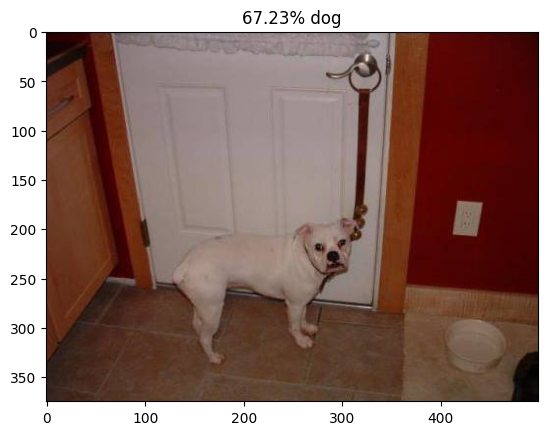

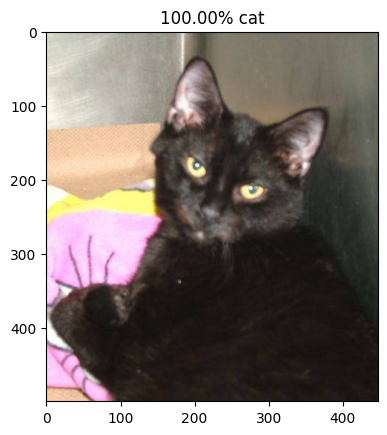

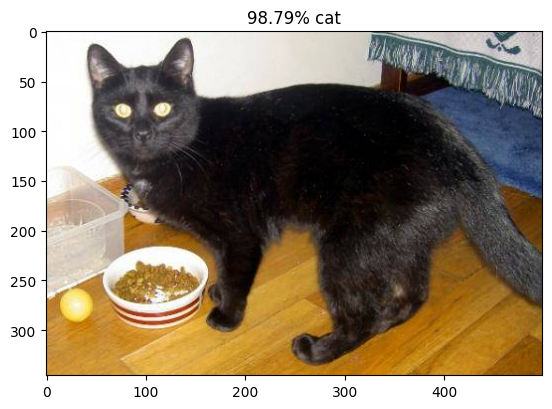

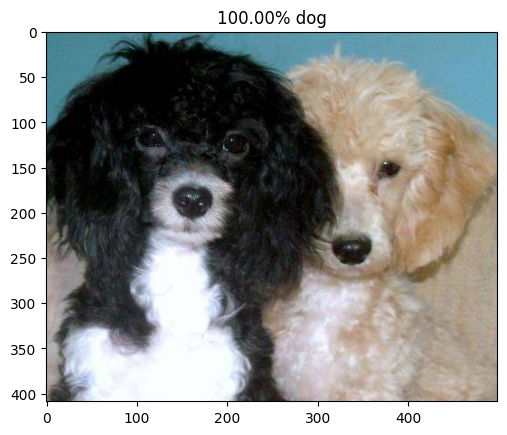

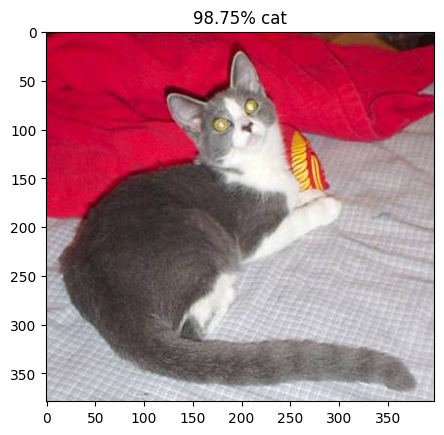

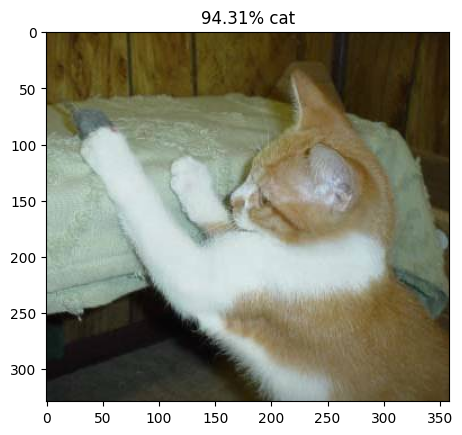

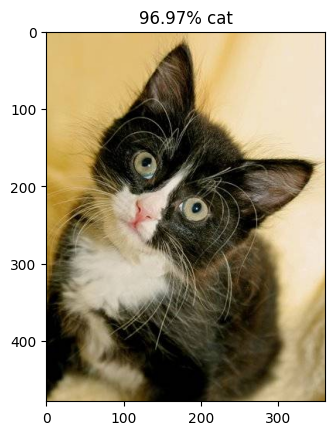

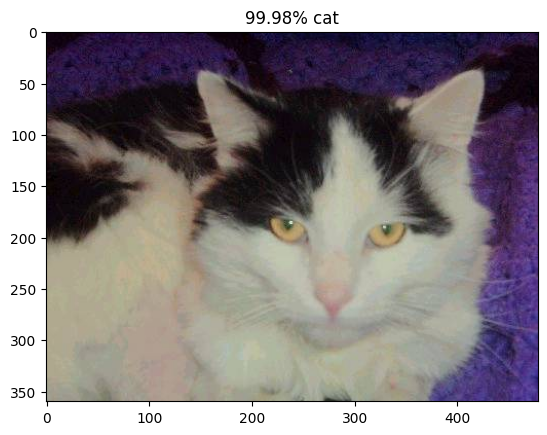

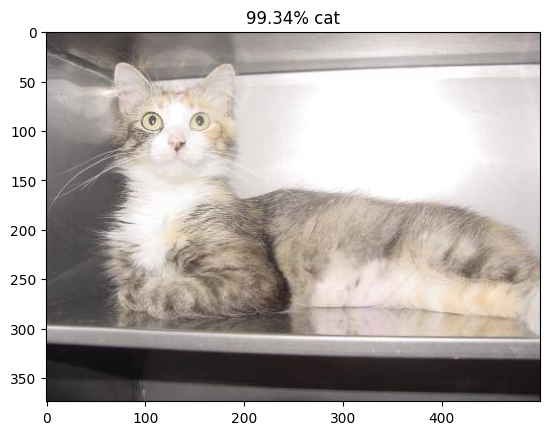

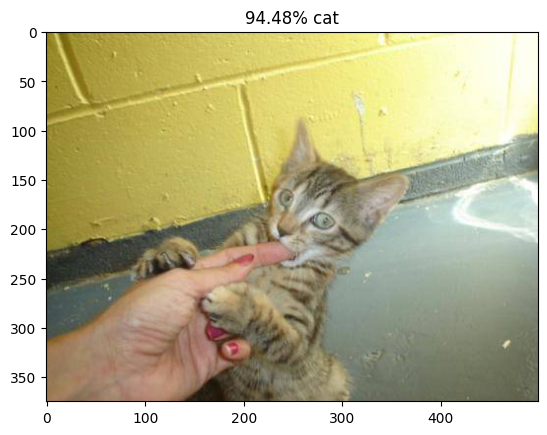

In [55]:
# Vẽ biểu đồ xác suất của các ảnh dự đoán, kèm theo hiển thị ảnh.
for index, probability in enumerate(probabilitiesVGG16):
    image_path = "working/dataset/testing_set/" + test_set.filenames[index]
    img = imread(image_path)
    plt.imshow(img)
    if probability > 0.5:
        plt.title("%.2f" % (probability[0]*100) + "% dog")
    else:
        plt.title("%.2f" % ((1-probability[0])*100) + "% cat")
    plt.show()

In [ ]:
# Tạo hàm để dự đoán trên một hình ảnh đơn lẻ
def detect_image(filepath):
    # Tải hình ảnh theo đường dẫn filepath, chuyển về kích thước (200,200) và hiển thị ra màn hình
    test_image = load_img(filepath, target_size = (200,200))
    plt.imshow(test_image)
    
    # Chuyển hình ảnh sang dạng numpy array để phù hợp với input của model
    test_image = img_to_array(test_image)
    
    # Thêm một chiều mới vào đầu mảng numpy, để phù hợp với input shape của model
    test_image = np.expand_dims(test_image, axis = 0)
    
    # Dự đoán kết quả của hình ảnh đầu vào bằng cách sử dụng model đã huấn luyện
    result = model.predict(test_image)
    
    # Lấy thông tin về cách mã hóa các lớp từ tập train, để biết được kết quả dự đoán là chó hay mèo
    train_set.class_indices
    
    # Nếu kết quả dự đoán của model là 1, tức là đó là hình của chó, gán cho biến prediction là 'dog'
    if result[0][0] == 1:
        prediction = 'dog'
    # Ngược lại, nếu kết quả dự đoán của model là 0, tức là đó là hình của mèo, gán cho biến prediction là 'cat'
    else:
        prediction = 'cat'
    # Đặt tiêu đề cho hình ảnh đã dự đoán là 'dog' hoặc 'cat' tùy thuộc vào kết quả dự đoán
    plt.title(prediction)

# Kiểm tra xem hình ảnh có tồn tại hay không
# pathAnimal = 'working/dataset/testing_set/Test/4670.jpg'
pathAnimal = 'img_outside/4.png' # sử dụng hình ảnh từ thực tế

if os.path.exists(pathAnimal):
    # Nếu hình ảnh tồn tại, in ra màn hình đường dẫn của hình ảnh đó
    print(f'{pathAnimal} exists')
    # Thực hiện dự đoán trên hình ảnh đó bằng cách gọi hàm detect_image
    detect_image(pathAnimal)
    
else:
    # Nếu hình ảnh không tồn tại, in ra màn hình đường dẫn của hình ảnh đó và thông báo rằng hình ảnh không tồn tại
    print(f'{pathAnimal} does not exist')

# detect_image('working/dataset/testing_set/Test/5490.jpg') # tắt ở đây để thêm dòng check image exists

Dựa trên kết quả kiểm định của mô hình, ta có thể thấy rằng mô hình VGG16 đã đạt được độ chính xác cao hơn (90.9%).

Điều này cho thấy rằng việc sử dụng mô hình VGG16 đã giúp tiết kiệm được thời gian huấn luyện so với việc sử dụng mô hình CNN truyền thống.

Vì vậy, khi đối diện với các bài toán phân loại hình ảnh có số lượng lớn các lớp và dữ liệu huấn luyện đầy đủ, sử dụng các kiến trúc mạng học sâu tiên tiến như VGG16 có thể giúp chúng ta tiết kiệm thời gian và đạt được kết quả tốt hơn.

## *Danh sách tài liệu tham khảo*

- [Đắm mình vào học sâu](https://d2l.aivivn.com/index.html)
- [VGG-16 CNN Model](https://www.geeksforgeeks.org/vgg-16-cnn-model/)
- [Tìm hiểu về mạng tích chập (CNN)](https://viblo.asia/p/deep-learning-tim-hieu-ve-mang-tich-chap-cnn-maGK73bOKj2)
- [Thuật toán CNN (Convolutional Neural Network)](https://topdev.vn/blog/thuat-toan-cnn-convolutional-neural-network/)
- [Cat-Dog Classification using Convolutional Neural Network in Python](https://www.geeksforgeeks.org/cat-dog-classification-using-convolutional-neural-network-in-python/)
- [Dogs vs Cats using Custom CNN & VGG16 Model](https://www.kaggle.com/code/vipulshinde/dogs-vs-cats-using-custom-cnn-vgg16-model/notebook)

### File data dogs-vs-cats

- [dogs-vs-cats Data (test1.zip, train.zip, sampleSubmission.csv)](https://www.kaggle.com/competitions/dogs-vs-cats/data)